## Introduction

Cancer-Net BCa is a large-scale breast MRI image dataset for the prediction of pCR. The dataset consists of two classes: No pCR (0), and pCR (1). The images are provided as a single directory, and labels for the images are provided in the metadata file.

In [1]:
# Check GPU Availability

import tensorflow as tf

# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is not available. Using CPU.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


## Install Packages

In [2]:
pip install scikit-image

In [3]:
pip install itk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 87.4 MB/s eta 0:00:00


## Loading Libraries

In [138]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy import ndimage
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mounting Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

The image data is stored in a single directory, namely `CDIs_images_nifti`. Labels are provided in the metadata named `metadata.csv`.

In [6]:
# Loading Data
image_dir = '/content/drive/MyDrive/Colab Notebooks/CDIs_images_nifti'
metadata_file = '/content/drive/MyDrive/Colab Notebooks/metadata.csv'
# Load metadata and replace missing entries
metadata = pd.read_csv(metadata_file)

## Exploratory Data Analysis

---




In [7]:
metadata.replace(np.nan, 'Unknown', regex=True, inplace=True)
metadata.head()

,patient_id,pCR,age,race,lesion type,HR/HER2,SBR grade,MRLD,analysis cohort
0,ACRIN-6698-115987,False,42.0,Multiple Races,Multiple masses,HR - / HER2 - (TN),III (High),4.0,False
1,ACRIN-6698-860901,True,49.0,Unknown,Single mass,HR - / HER2 - (TN),III (High),4.6,True
2,ACRIN-6698-413211,False,66.0,White,Multiple masses,HR + / HER2 +,III (High),3.4,True
3,ACRIN-6698-801641,False,53.0,White,Multiple masses,HR - / HER2 - (TN),III (High),3.9,True
4,ACRIN-6698-408692,True,25.0,White,Multiple masses,HR - / HER2 - (TN),III (High),4.3,True


In [8]:
# metadata info
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       253 non-null    object 
 1   pCR              253 non-null    bool   
 2   age              253 non-null    float64
 3   race             253 non-null    object 
 4   lesion type      253 non-null    object 
 5   HR/HER2          253 non-null    object 
 6   SBR grade        253 non-null    object 
 7   MRLD             253 non-null    float64
 8   analysis cohort  253 non-null    bool   
dtypes: bool(2), float64(2), object(5)
memory usage: 14.5+ KB


In [9]:
metadata.columns

Index(['patient_id', 'pCR', 'age', 'race', 'lesion type', 'HR/HER2',
       'SBR grade', 'MRLD', 'analysis cohort'],
      dtype='object')

In [10]:
# Image Data
# Set display range (in log10 scale, see below)
display_range = (-5, 5)
# Select cases to view
#np.random.seed(28)
patient_file_list = os.listdir(image_dir)
indices = np.random.choice(list(range(len(patient_file_list))), 9)
print(len(patient_file_list))

253


In [11]:
# Image Data
print(indices)
for file_name in patient_file_list:
    print(file_name)

[ 87 251  11 138  69  12  94  70 234]
ACRIN-6698-102212_CDIs_img.nii
ACRIN-6698-107700_CDIs_img.nii
ACRIN-6698-104268_CDIs_img.nii
ACRIN-6698-116603_CDIs_img.nii
ACRIN-6698-103939_CDIs_img.nii
ACRIN-6698-118307_CDIs_img.nii
ACRIN-6698-115987_CDIs_img.nii
ACRIN-6698-139973_CDIs_img.nii
ACRIN-6698-144302_CDIs_img.nii
ACRIN-6698-131961_CDIs_img.nii
ACRIN-6698-130580_CDIs_img.nii
ACRIN-6698-138027_CDIs_img.nii
ACRIN-6698-156163_CDIs_img.nii
ACRIN-6698-152090_CDIs_img.nii
ACRIN-6698-150547_CDIs_img.nii
ACRIN-6698-146987_CDIs_img.nii
ACRIN-6698-145777_CDIs_img.nii
ACRIN-6698-148357_CDIs_img.nii
ACRIN-6698-169918_CDIs_img.nii
ACRIN-6698-165925_CDIs_img.nii
ACRIN-6698-179568_CDIs_img.nii
ACRIN-6698-162562_CDIs_img.nii
ACRIN-6698-179369_CDIs_img.nii
ACRIN-6698-172366_CDIs_img.nii
ACRIN-6698-209967_CDIs_img.nii
ACRIN-6698-203060_CDIs_img.nii
ACRIN-6698-188700_CDIs_img.nii
ACRIN-6698-208650_CDIs_img.nii
ACRIN-6698-213913_CDIs_img.nii
ACRIN-6698-196064_CDIs_img.nii
ACRIN-6698-220925_CDIs_img.nii
A

<ipython-input-12-7ca2bd5d6477>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet').copy()


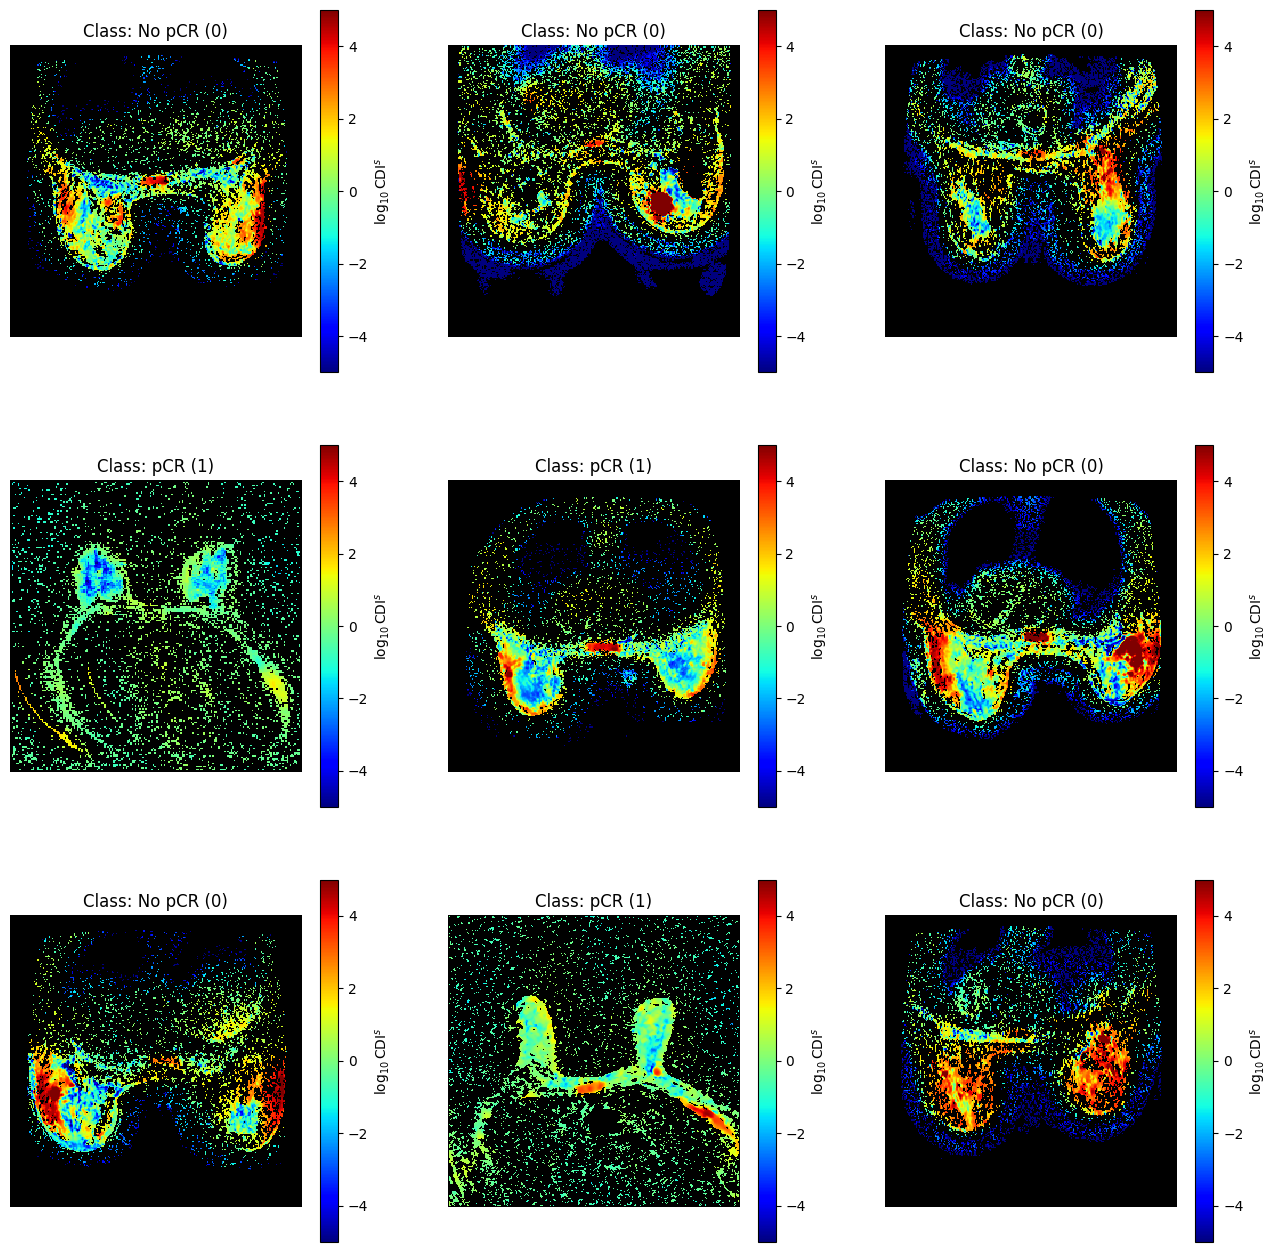

In [12]:
# Show a grid of 9 images
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
class_names = ('No pCR', 'pCR')
for index, ax in zip(indices, axes.ravel()):
    # Load the MRI image
    cdis_file = os.path.join(image_dir, patient_file_list[index])
    cdis_volume = nib.load(cdis_file).get_fdata()

    # Grab middle slice
    cdis_display = cdis_volume[..., cdis_volume.shape[-1]//2]

    # Convert to log10 scale
    valid = cdis_display > 0
    cdis_display[valid] = np.log10(cdis_display[valid])

    # Mask invalid voxels
    cdis_display = np.ma.array(cdis_display, mask=~valid)

    # Get class
    patient_id = patient_file_list[index].split('_')[0]
    cls = int(metadata.loc[metadata['patient_id'] == patient_id]['pCR'].values[0])

    # Display slice
    cmap = cm.get_cmap('jet').copy()
    cmap.set_bad('k')
    im = ax.imshow(
        cdis_display, interpolation='none', cmap=cmap,
        vmin=display_range[0], vmax=display_range[1]
    )
    plt.colorbar(im, ax=ax, label='$\log_{10}$CDI$^s$')
    ax.set_title('Class: {} ({})'.format(class_names[cls], cls))
    ax.axis('off')
    plt.savefig('MRI.png')
plt.show()

In [13]:
print(f"Dimensions of the image data for {cdis_file}: {cdis_volume.shape}")

Dimensions of the image data for /content/drive/MyDrive/Colab Notebooks/CDIs_images_nifti/ACRIN-6698-938719_CDIs_img.nii: (256, 256, 39)


## Examining the Metadata
Metadata for all cases is available in `metadata.csv`. This file includes:
* Patient ID (key "patient_id")
* pCR status (key: "pCR")
* Age (key: "age")
* Race (if available, key: "race")
* Lesion type (key: "lesion type")
* Genetic subtype (key: "HR/HER2")
* Scarff-Bloom-Richardson grade (key: "SBR grade")
* Largest diameter (key: "MRLD")
* Flag for inclusion in ACRIN-6698 analysis cohort (key: "analysis cohort")

Let's first define some functions to display the metadata:

In [51]:
def pie_chart(ax, data, labels, title=None):
    """Helper to plot a pie chart"""
    orig_data = np.asarray(data)
    orig_labels = np.asarray(labels)
    data = data.copy()
    labels = labels.copy()
    order = np.argsort(data)
    data[1::2] = orig_data[order[:len(data)//2]]
    data[::2] = orig_data[order[len(data)//2:]]
    labels[1::2] = orig_labels[order[:len(data)//2]]
    labels[::2] = orig_labels[order[len(data)//2:]]
    ax.pie(data, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
    if title is not None:
        ax.set_title(title)

def subdivided_pie_chart(main_ax, sub_ax, data, labels, main_label_set, title=None):
    """Helper to create paired pie charts for limited-data categories"""
    main_labels, main_counts = [], []
    sub_labels, sub_counts = [], []
    for label, count in zip(labels, data):
        if label in main_label_set:
            main_labels.append(label)
            main_counts.append(count)
        else:
            sub_labels.append(label)
            sub_counts.append(count)
    main_labels.append('Other')
    main_counts.append(sum(sub_counts))
    sub_title = None
    if title is not None:
        sub_title = title + ' - Other ({} cases)'.format(main_counts[-1])
    pie_chart(main_ax, main_counts, main_labels, title=title)
    pie_chart(sub_ax, sub_counts, sub_labels, title=sub_title)

def histogram(ax, data, bins, title=None):
    """Helper to plot a histogram"""
    labels = ['[{}, {})'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    ax.hist(data, bins, label=labels, rwidth=0.9)
    ax.set_xticks(bins[:-1] + (bins[1] - bins[0])/2)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Number of Patients')
    ax.set_xlabel(title)
    if title is not None:
        ax.set_title(title)

### pCR Status, Lesion Type, Genetic Subtype, SBR Grade, Race

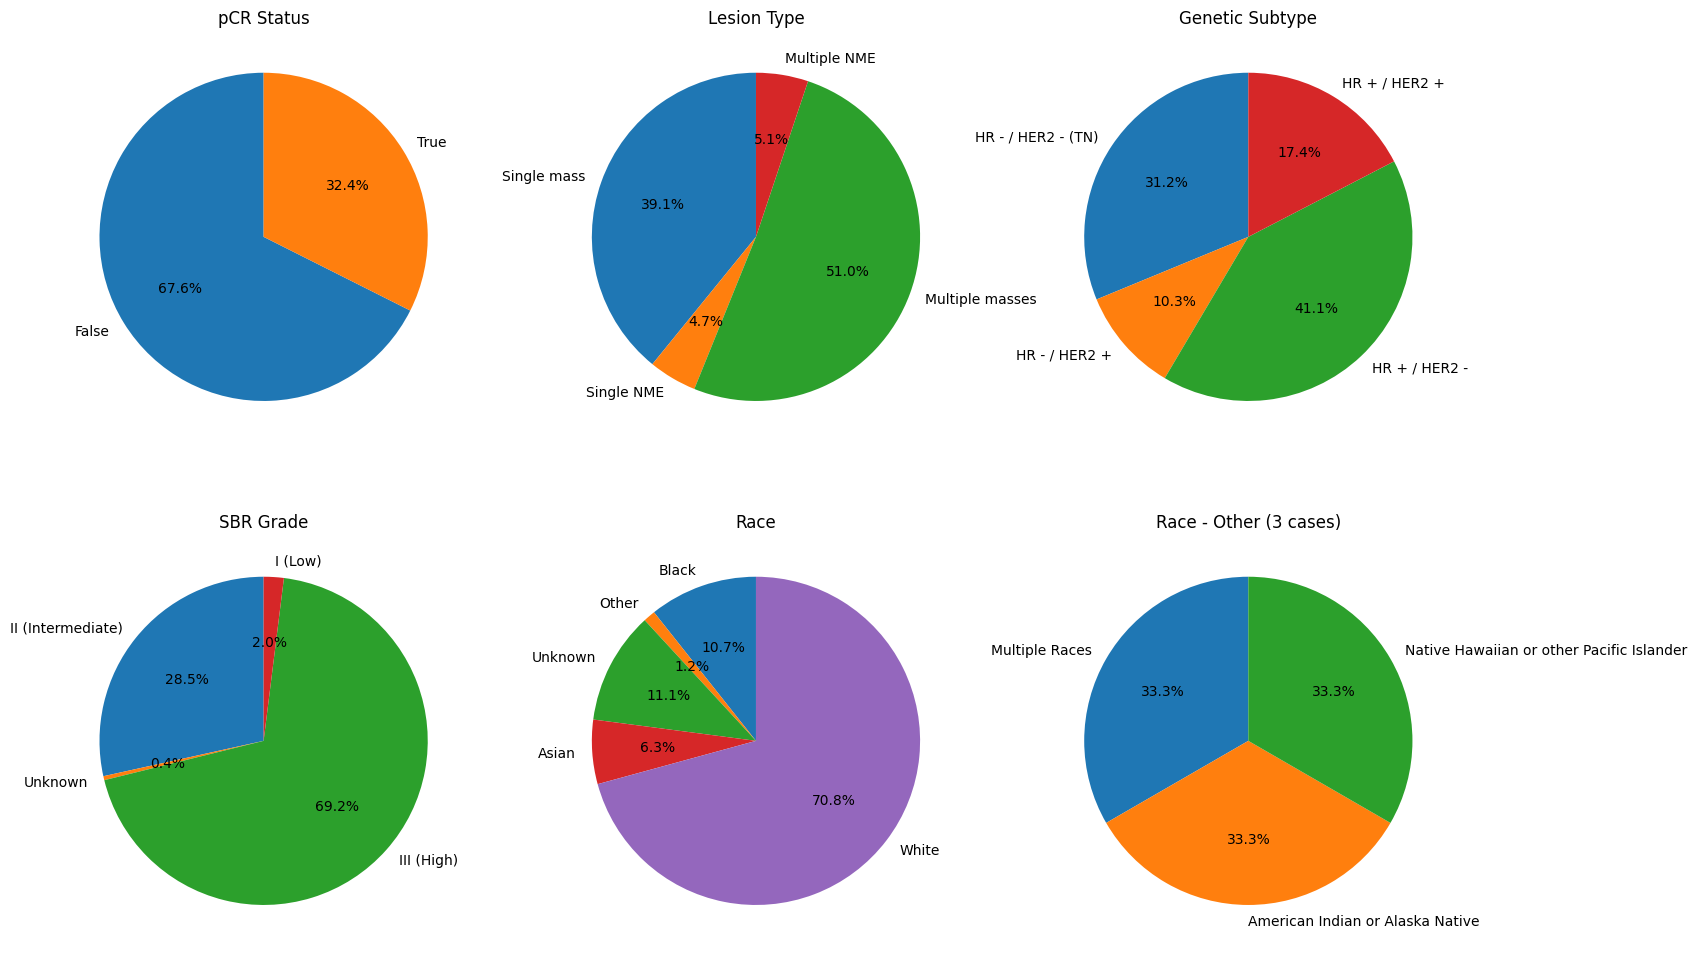

In [53]:
# Get data for pie charts
pcr_labels, pcr_counts = np.unique(metadata['pCR'], return_counts=True)
race_labels, race_counts = np.unique(metadata['race'], return_counts=True)
type_labels, type_counts = np.unique(metadata['lesion type'], return_counts=True)
gen_labels, gen_counts = np.unique(metadata['HR/HER2'], return_counts=True)
sbr_labels, sbr_counts = np.unique(metadata['SBR grade'], return_counts=True)


# Display pie charts
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
pie_chart(axes[0], pcr_counts, pcr_labels, title='pCR Status')
pie_chart(axes[1], type_counts, type_labels, title='Lesion Type')
pie_chart(axes[2], gen_counts, gen_labels, title='Genetic Subtype')
pie_chart(axes[3], sbr_counts, sbr_labels, title='SBR Grade')
subdivided_pie_chart(
    axes[4], axes[5], race_counts, race_labels,
    {'White', 'Black', 'Asian', 'Unknown'}, title='Race'
)
plt.savefig('pie_charts.png')
plt.show()

### Age and Lesion Diameter

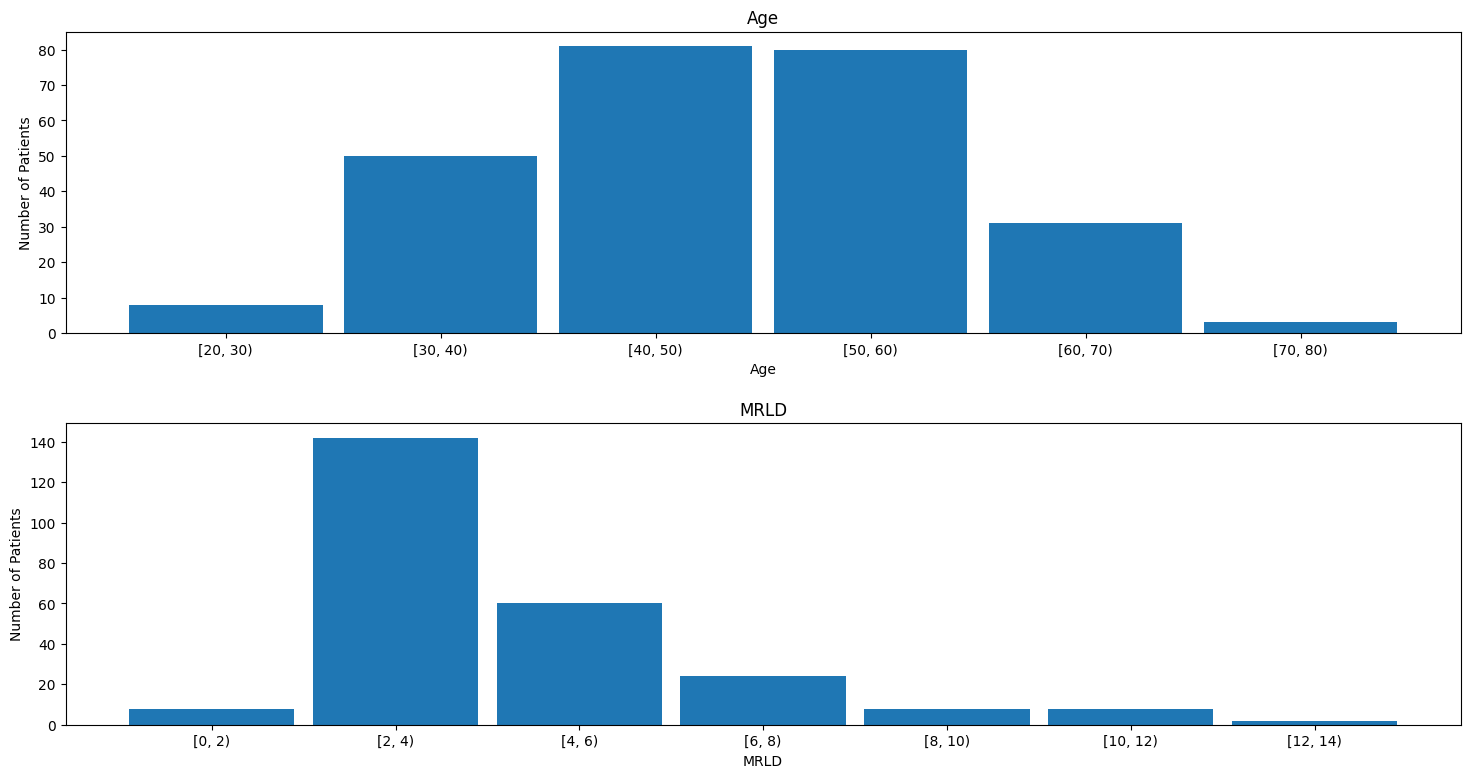

In [16]:
# Make bins
age_bins = np.arange(20, 81, 10)
mrld_bins = np.arange(0, 15, 2)

# Display histograms
fig, axes = plt.subplots(2, 1, figsize=(18, 9))
axes = axes.ravel()
histogram(axes[0], metadata['age'], age_bins, title='Age')
histogram(axes[1], metadata['MRLD'], mrld_bins, title='MRLD')
plt.subplots_adjust(hspace=0.3)
plt.savefig('age.png')
plt.show()

## Prepare the dataset:

 Split the images and their corresponding labels into training, validation, and testing datasets. In this case, the labels are 'No pCR' and 'pCR'.

```
# This is formatted as code
```



In [17]:
# Initialize an empty list to hold image data and labels
data = []
labels = []

# Load the MRI images and their labels
for index in range(len(patient_file_list)):
    # Load the MRI image
    cdis_file = os.path.join(image_dir, patient_file_list[index])
    cdis_volume = nib.load(cdis_file).get_fdata()

    # Grab middle slice (adjust as necessary for your use case)
    cdis_display = cdis_volume[..., cdis_volume.shape[-1]//2]

    # Convert to log10 scale
    valid = cdis_display > 0
    cdis_display[valid] = np.log10(cdis_display[valid])

    # Mask invalid voxels
    cdis_display = np.ma.array(cdis_display, mask=~valid)

    # Add the image data to the list
    data.append(cdis_display)

    # Get class
    patient_id = patient_file_list[index].split('_')[0]
    cls = int(metadata.loc[metadata['patient_id'] == patient_id]['pCR'].values[0])

    # Add the label to the list
    labels.append(cls)

# Convert the lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


<ipython-input-17-34b7f05b8d53>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


## Preprocess the data:

 Normalize the pixel values of your images (in this case, the values are already preprocessed in your code)

In [18]:
# Desired image dimensions (change as needed)
desired_shape = (128, 128)

# Initialize lists to hold processed images
X_train_processed = []
X_val_processed = []
X_test_processed = []

# Process training images
for img in X_train:
    reshaped_img = ndimage.zoom(img, (desired_shape[0]/img.shape[0], desired_shape[1]/img.shape[1]))
    X_train_processed.append(reshaped_img)

# Process validation images
for img in X_val:
    reshaped_img = ndimage.zoom(img, (desired_shape[0]/img.shape[0], desired_shape[1]/img.shape[1]))
    X_val_processed.append(reshaped_img)

# Process test images
for img in X_test:
    reshaped_img = ndimage.zoom(img, (desired_shape[0]/img.shape[0], desired_shape[1]/img.shape[1]))
    X_test_processed.append(reshaped_img)

# Convert lists to numpy arrays
X_train_processed = np.array(X_train_processed)
X_val_processed = np.array(X_val_processed)
X_test_processed = np.array(X_test_processed)

# Now find the minimum and maximum pixel values across all images
min_val = np.min(X_train_processed)
max_val = np.max(X_train_processed)

# Perform min-max normalization
X_train_normalized = (X_train_processed - min_val) / (max_val - min_val)
X_val_normalized = (X_val_processed - min_val) / (max_val - min_val)
X_test_normalized = (X_test_processed - min_val) / (max_val - min_val)

## Build The Model

Perfect! They are normalized.

In [19]:
# Initialize the model object
model = Sequential()

# Add a convolutional layer with 32 filters, each of size 3x3.
# We use the ReLU activation function and specify the input shape to match our images.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))

# Add a max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a dense layer with 64 units
model.add(Dense(64, activation='relu'))

# Add the output layer with 2 units (for 'No pCR' and 'pCR')
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Train the model:

 Test the model's performance on the test dataset. This gives us an estimate of how our model will perform on unseen data. This is done using the evaluate() function in Keras.

In [20]:
# Define your target image size
target_size = (128, 128)

# Resize all images in the training, validation, and test datasets
X_train_resized = np.array([resize(img, target_size) for img in X_train_normalized])
X_val_resized = np.array([resize(img, target_size) for img in X_val_normalized])
X_test_resized = np.array([resize(img, target_size) for img in X_test_normalized])

# Convert to float32
X_train_final = X_train_resized.astype('float32')
X_val_final = X_val_resized.astype('float32')
X_test_final = X_test_resized.astype('float32')

In [21]:
# Print the shape of the first image in the training set
print(X_train_final[0].shape)

(128, 128)


In [22]:
# Define the function to preprocess a single image
def preprocess_image(image, target_size=(128, 128)):
    # Resize the image
    image_resized = resize(image, target_size)

    # Fill the masked values with 0
    if isinstance(image_resized, np.ma.MaskedArray):
        image_resized = image_resized.filled(0)

    # Cast to float32 type
    return image_resized.astype('float32')

# Apply the preprocessing function to each image in each dataset
X_train_final = np.array([preprocess_image(img) for img in X_train_final])
X_val_final = np.array([preprocess_image(img) for img in X_val_final])
X_test_final = np.array([preprocess_image(img) for img in X_test_final])

# Print the shape of the first image in the training set
print(X_train_final[0].shape)
X_train_final.dtype
X_val_final.dtype
X_test_final.dtype

(128, 128)


dtype('float32')

In [23]:
X_train_final.shape

(151, 128, 128)

In [24]:
# X_train_final = X_train_final.astype('float32')
# X_val_final = X_val_final.astype('float32')
# X_test_final = X_test_final.astype('float32')


In [25]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

In [26]:
print('Min and max pixel values for the training set: ', np.min(X_train_final), np.max(X_train_final))
print('Min and max pixel values for the validation set: ', np.min(X_val_final), np.max(X_val_final))
print('Min and max pixel values for the test set: ', np.min(X_test_final), np.max(X_test_final))

Min and max pixel values for the training set:  0.0 1.0
Min and max pixel values for the validation set:  0.053745348 1.0003775
Min and max pixel values for the test set:  0.03406243 0.9810401


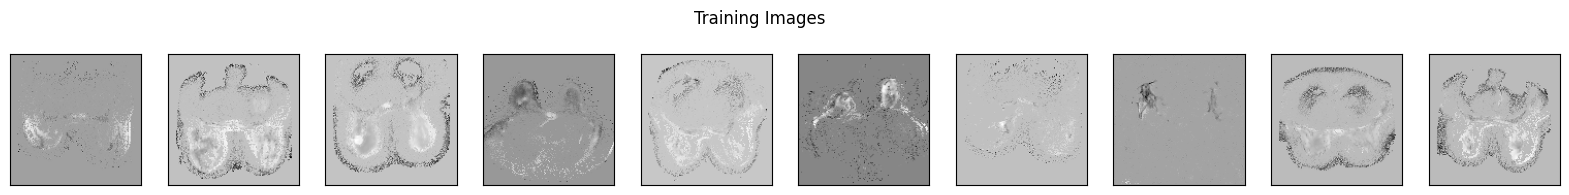

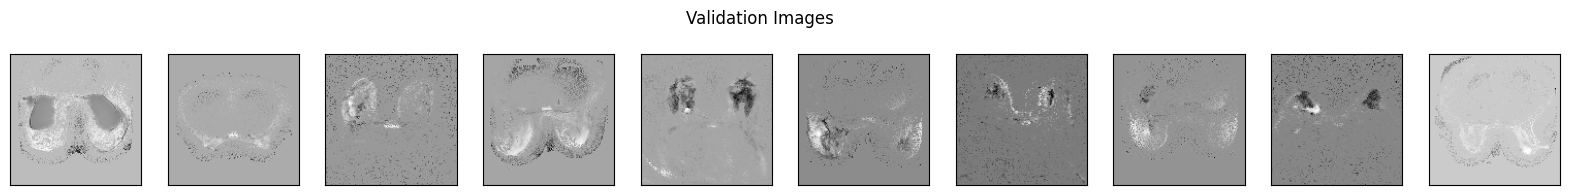

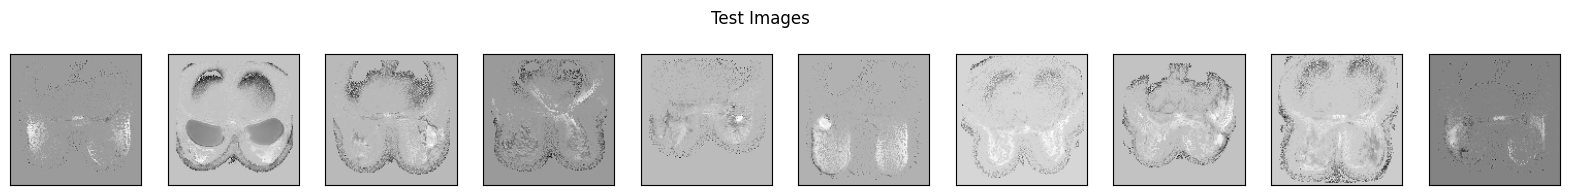

In [27]:
# Function to display a grid of images
def display_images(images, title):
    n = len(images)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.savefig('model.png')
    plt.show()

# Select the first 10 images from each set
train_images = X_train_final[:10]
val_images = X_val_final[:10]
test_images = X_test_final[:10]

# Display the images
display_images(train_images, "Training Images")
display_images(val_images, "Validation Images")
display_images(test_images, "Test Images")

In [28]:
history = model.fit(X_train_final, y_train, validation_data=(X_val_final, y_val), epochs=50, batch_size=128)


Epoch 1/50
2/2 [==============================] - 12s 425ms/step - loss: 1.2289 - accuracy: 0.6689 - val_loss: 0.6890 - val_accuracy: 0.6667
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 0.9791 - accuracy: 0.6225 - val_loss: 1.5328 - val_accuracy: 0.3333
Epoch 3/50
2/2 [==============================] - 0s 34ms/step - loss: 1.3547 - accuracy: 0.4305 - val_loss: 0.6828 - val_accuracy: 0.6667
Epoch 4/50
2/2 [==============================] - 0s 32ms/step - loss: 0.6856 - accuracy: 0.6689 - val_loss: 0.6618 - val_accuracy: 0.6667
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 0.6657 - accuracy: 0.6689 - val_loss: 0.6448 - val_accuracy: 0.6667
Epoch 6/50
2/2 [==============================] - 0s 35ms/step - loss: 0.6455 - accuracy: 0.6689 - val_loss: 0.6475 - val_accuracy: 0.6667
Epoch 7/50
2/2 [==============================] - 0s 34ms/step - loss: 0.6450 - accuracy: 0.6689 - val_loss: 0.6364 - val_accuracy: 0.6667
Epoch 8/50
2/2 [=========

## Evaluate your model:

Use model.evaluate to evaluate your model on unseen data.

In [29]:
score = model.evaluate(X_test_final, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6079567074775696
Test accuracy: 0.7058823704719543


## The Performance of The Model


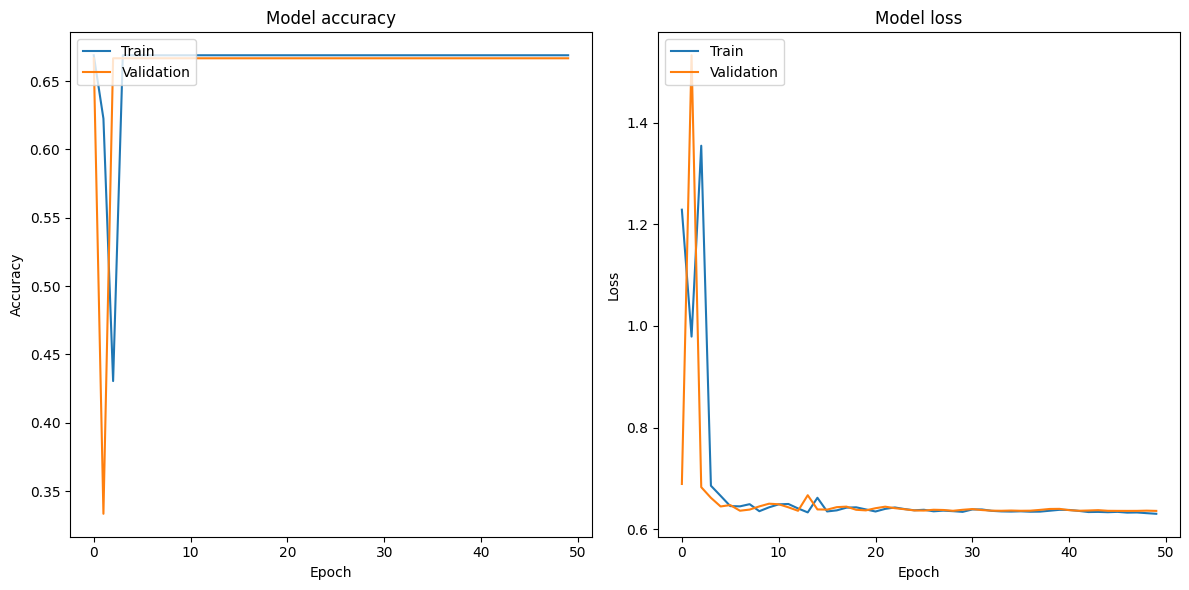

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('model_performance.png')
plt.show()

We observe that the training loss decreasing but validation loss increasing after epoch 8. Our model might be overfitting. This means the model is learning the training data too well, to the point of memorizing it, and failing to generalize to unseen data.

To fix this we can apply one of the following methods:

1/ Data Augmentation: By artificially increasing the size of the training set, the model can learn more generalized features. Common data augmentation techniques for images include rotation, scaling, translation, and flipping. ImageDataGenerator in Keras can help with this.

2/ Dropout: Dropout is a regularization technique where randomly selected neurons are ignored during training. This helps prevent over-dependence on any single neuron and helps generalize the model. Dropout can be added to layers in the CNN like so: Dropout(rate).

3/ Early Stopping: Early stopping halts the training process when the model's performance on the validation set stops improving, even if the training loss continues to decrease. This can be implemented using callbacks in Keras.

4/ Reduce Model Complexity: If your model has too many layers or too many neurons, it may be too complex and could overfit. Try reducing the number of layers or the number of neurons per layer.

5/ Weight Regularization: Weight regularization techniques like L1 or L2 regularization discourage the weights from becoming too large and causing overfitting.


However, it is a good idea to try these strategies in combination to optimize the performance of the model.

In [31]:
X_train_final.shape,X_test_final.shape,X_val_final.shape

((151, 128, 128), (51, 128, 128), (51, 128, 128))

In [32]:
import numpy as np

X_train_final1 = np.expand_dims(X_train_final, axis=-1)  # Add channel dimension to training data
X_test_final1 = np.expand_dims(X_test_final, axis=-1)    # Add channel dimension to test data
X_val_final1 = np.expand_dims(X_val_final, axis=-1)      # Add channel dimension to validation data
X_train_final1 = np.repeat(X_train_final1, 3, axis=-1)     # Convert grayscale to RGB format for training data
X_test_final1 = np.repeat(X_test_final1, 3, axis=-1)       # Convert grayscale to RGB format for test data
X_val_final1 = np.repeat(X_val_final1, 3, axis=-1)         # Convert grayscale to RGB format for validation data

X_train_final1.shape,X_test_final1.shape,X_val_final1.shape

((151, 128, 128, 3), (51, 128, 128, 3), (51, 128, 128, 3))

In [33]:
# Now find the minimum and maximum pixel values across all images
min_val = np.min(X_train_final1)
max_val = np.max(X_train_final1)

# Perform min-max normalization
X_train_final1 = (X_train_final1 - min_val) / (max_val - min_val)
X_val_final1 = (X_val_final1 - min_val) / (max_val - min_val)
X_test_final1 = (X_test_final1 - min_val) / (max_val - min_val)

In [34]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
# Add more layers as needed

# Assuming you have already loaded X_train_final, X_test_final, X_val_final, y_train, y_test, y_val

# Data normalization and scaling
# X_train_final1 = X_train_final1.astype('float32') / 255.0
# X_test_final1 = X_test_final1.astype('float32') / 255.0
# X_val_final1 = X_val_final1.astype('float32') / 255.0

# Define the hyperparameters to search over
batch_sizes = [16, 32, 64]
num_epochs = [20, 30, 50]
dropout_rates = [0.2, 0.3, 0.4]

best_accuracy = 0.0
best_params = {}

for batch_size in batch_sizes:
    for epochs in num_epochs:
        for dropout_rate in dropout_rates:
            # Create a new model for each combination of hyperparameters
            model1 = Sequential()
            model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
            model1.add(MaxPooling2D(pool_size=(2, 2)))
            model1.add(Dropout(dropout_rate))

            # Add more layers as needed

            model1.add(Flatten())
            model1.add(Dense(64, activation='relu'))
            model1.add(Dense(1, activation='sigmoid'))

            # Compile the model
            model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            # Early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=3)

            # Train the model
            model1.fit(X_train_final1, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_final1, y_val), callbacks=[early_stopping])

            # Evaluate the model on the test set
            _, accuracy = model1.evaluate(X_test_final1, y_test)

            # Check if the current hyperparameters resulted in better accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'dropout_rate': dropout_rate
                }

print("Best Hyperparameters:")
print(best_params)
print("Best Test Accuracy:", best_accuracy)



Epoch 1/20
10/10 [==============================] - 2s 32ms/step - loss: 6.2251 - accuracy: 0.4702 - val_loss: 5.9756 - val_accuracy: 0.6667
Epoch 2/20
10/10 [==============================] - 0s 8ms/step - loss: 3.0735 - accuracy: 0.5828 - val_loss: 0.7295 - val_accuracy: 0.3333
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.8654 - accuracy: 0.6556 - val_loss: 0.6783 - val_accuracy: 0.6667
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6404 - accuracy: 0.6821 - val_loss: 0.6489 - val_accuracy: 0.6667
Epoch 5/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6233 - accuracy: 0.6755 - val_loss: 0.6707 - val_accuracy: 0.6471
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.5965 - accuracy: 0.7086 - val_loss: 0.8335 - val_accuracy: 0.3333
Epoch 7/20
2/2 [==============================] - 0s 32ms/step - loss: 0.6218 - accuracy: 0.7059
Epoch 1/20
10/10 [==============================] - 1s 25ms/st

## Data Augmentation, Droupout, and Weight Regularization:


In [143]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Optimal hyperparameters
batch_size = 16
num_epochs = 20
dropout_rate = 0.2

# Create model2
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3),
                  kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(dropout_rate))

# Add more layers as needed

model2.add(Flatten())
model2.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model2.add(Dropout(dropout_rate))
model2.add(Dense(1, activation='sigmoid'))

# Compile model2
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model with data augmentation
history2 = model2.fit(datagen.flow(X_train_final1, y_train, batch_size=batch_size),
                     validation_data=(X_val_final1, y_val),
                     epochs=num_epochs, callbacks=[early_stopping])


Epoch 1/20
10/10 [==============================] - 2s 71ms/step - loss: 2.0223 - accuracy: 0.5960 - val_loss: 1.6338 - val_accuracy: 0.6667
Epoch 2/20
10/10 [==============================] - 1s 60ms/step - loss: 1.5741 - accuracy: 0.5828 - val_loss: 1.3975 - val_accuracy: 0.6667
Epoch 3/20
10/10 [==============================] - 1s 59ms/step - loss: 1.3050 - accuracy: 0.6623 - val_loss: 1.2143 - val_accuracy: 0.6667
Epoch 4/20
10/10 [==============================] - 1s 57ms/step - loss: 1.1799 - accuracy: 0.6490 - val_loss: 1.1047 - val_accuracy: 0.6667
Epoch 5/20
10/10 [==============================] - 1s 56ms/step - loss: 1.0946 - accuracy: 0.6424 - val_loss: 1.0538 - val_accuracy: 0.6667
Epoch 6/20
10/10 [==============================] - 1s 57ms/step - loss: 1.0084 - accuracy: 0.6689 - val_loss: 1.0033 - val_accuracy: 0.6667
Epoch 7/20
10/10 [==============================] - 1s 58ms/step - loss: 0.9788 - accuracy: 0.6689 - val_loss: 0.9799 - val_accuracy: 0.6667
Epoch 8/20
10

This code adds dropout to the model with a dropout rate of 0.25 for the convolutional layers and 0.5 for the dense layers. It also adds L2 weight regularization with a strength of 0.01. Data augmentation is performed with random rotations, zooms, shifts, shears, and flips. Early stopping is used to halt training when the validation loss doesn't improve for 3 epochs.

In [144]:
# Evaluate the model on the test data
test_loss, test_acc = model2.evaluate(X_test_final1, y_test)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)


2/2 [==============================] - 0s 7ms/step - loss: 0.8455 - accuracy: 0.7059
Test Loss:  0.8454784154891968
Test Accuracy:  0.7058823704719543


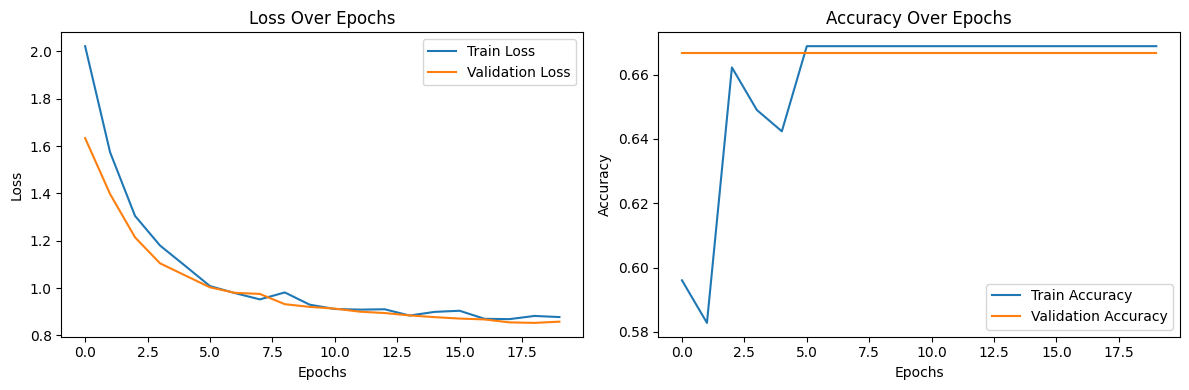

In [145]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('model2_perform01.png')
plt.show()


2/2 [==============================] - 0s 14ms/step


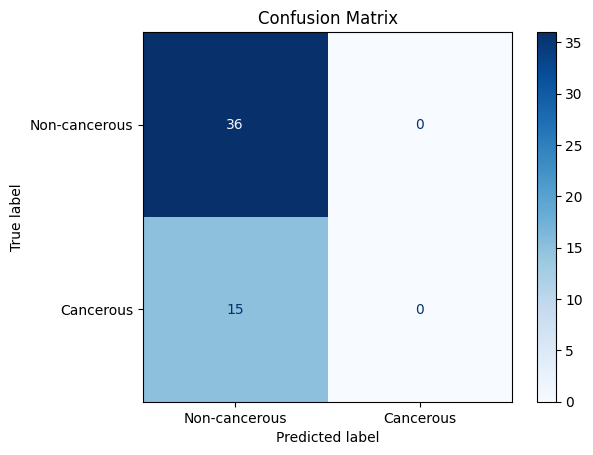

In [146]:
# Generate and plot the confusion matrix
y_pred = model_resnet50.predict(X_test_final_resnet50)
y_pred_binary = np.round(y_pred).flatten()
conf_matrix = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-cancerous', 'Cancerous'])
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('Confusion_Matrix_for_Model_2')
plt.show()

## ResNet50

In [140]:
# Assuming X_train_final, X_val_final, and X_test_final contain your image data
desired_size = (224, 224)

# Function to resize, convert to RGB, and normalize
def resize_convert_and_normalize(image):
    # Add an extra dimension to represent the single grayscale channel
    image = np.expand_dims(image, axis=-1)

    # Resize the image to the desired size
    image_resized = resize(image, desired_size)

    # Convert to RGB by repeating the grayscale channel 3 times
    image_rgb = np.repeat(image_resized, 3, axis=-1)

    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_rgb / 255.0

    return image_normalized

# Convert and normalize the images
X_train_final_resnet50 = np.array([resize_convert_and_normalize(image) for image in X_train_final])
X_val_final_resnet50 = np.array([resize_convert_and_normalize(image) for image in X_val_final])
X_test_final_resnet50 = np.array([resize_convert_and_normalize(image) for image in X_test_final])

# Load the ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the new model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet50.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet50 = model_resnet50.fit(X_train_final_resnet50, y_train, batch_size=64, epochs=10, validation_data=(X_val_final_resnet50, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet50.evaluate(X_test_final_resnet50, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
3/3 [==============================] - 5s 577ms/step - loss: 0.6964 - accuracy: 0.5033 - val_loss: 0.6495 - val_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 0s 63ms/step - loss: 0.6785 - accuracy: 0.6689 - val_loss: 0.6904 - val_accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 0s 58ms/step - loss: 0.6658 - accuracy: 0.6689 - val_loss: 0.6687 - val_accuracy: 0.6667
Epoch 4/10
3/3 [==============================] - 0s 57ms/step - loss: 0.6687 - accuracy: 0.6689 - val_loss: 0.6366 - val_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 0s 60ms/step - loss: 0.6377 - accuracy: 0.6689 - val_loss: 0.6496 - val_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 0s 56ms/step - loss: 0.6401 - accuracy: 0.6689 - val_loss: 0.6433 - val_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 0s 55ms/step - loss: 0.6457 - accuracy: 0.6689 - val_loss: 0.6523 - val_accuracy: 0.6667
Epoch 8/10
3/3 [==========

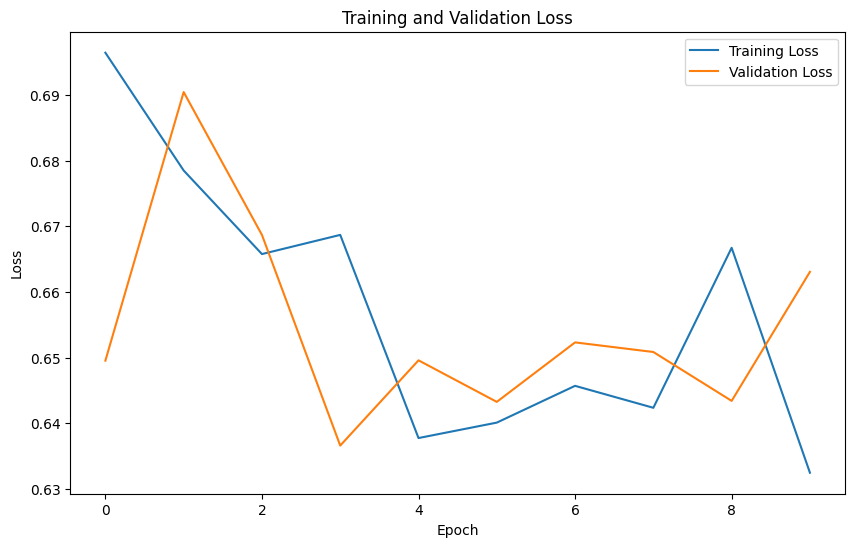

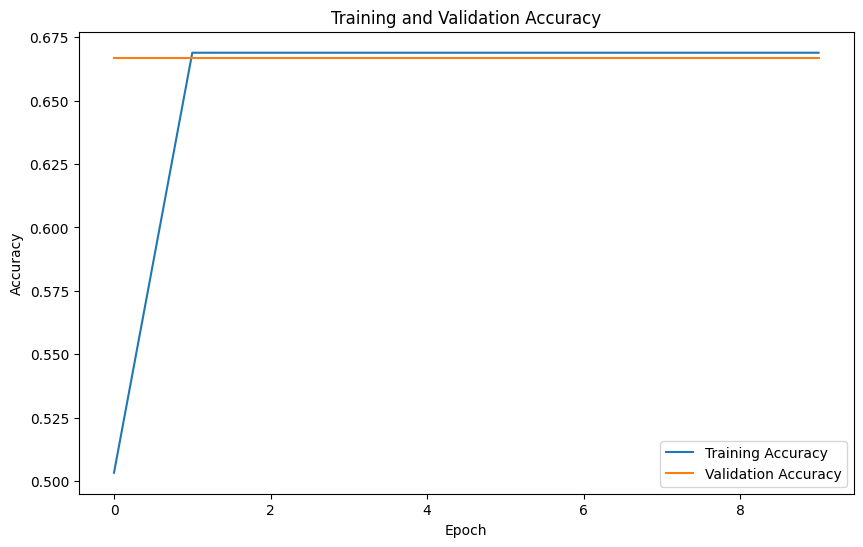

2/2 [==============================] - 0s 20ms/step - loss: 0.6546 - accuracy: 0.7059
Test Loss: 0.6546225547790527
Test Accuracy: 0.7058823704719543


In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have trained the model already and have the 'history' object

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Training_and_Validation_Loss.png')
plt.show()

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('training_and_validation_accuracy.png')
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet50.evaluate(X_test_final_resnet50, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)